# Final Project

### Group Members :- Aditya Kesari, Fiona Wang, Dhruv Rana

## 0. Import 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Label Colors

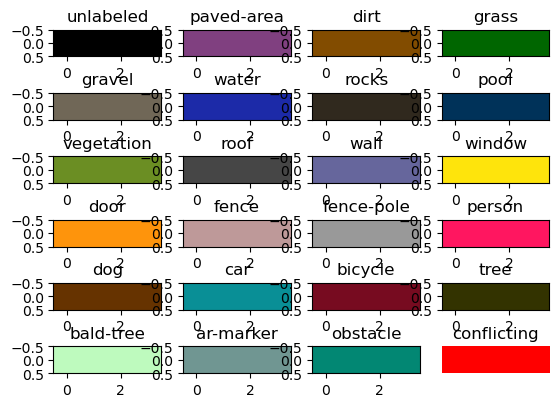

In [17]:
label_map = pd.read_csv("./archive/class_dict_seg.csv")

for index,label in enumerate(label_map["name"]):
    plt.subplot(6,4,index+1)
    (R,G,B) = label_map.iloc[index][1:]
    color = np.array([[[R,G,B],[R,G,B],[R,G,B],[R,G,B]]])
    plt.imshow(color)
    plt.title(label)
    plt.axis("off")

plt.show()
